<a href="https://colab.research.google.com/github/gandhimonil9823/Covid_Stock_Analysis/blob/main/Covid_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (183 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing trigge

In [2]:
!pip install -q pyproj==1.9.6

     |████████████████████████████████| 2.8MB 4.4MB/s 


In [3]:
!pip install pathpy
!pip install pyramid-arima
!pip install statsmodels

     |████████████████████████████████| 235kB 4.4MB/s 
     |████████████████████████████████| 604kB 4.3MB/s 


In [41]:

import pandas as pd
import matplotlib.pyplot as plt
import os
import statistics 
import numpy as np
# from mpl_toolkits.basemap import Basemap
%matplotlib inline
# import pathpy as pp
# from geopy import distance
# from geopy.distance import geodesic
import itertools
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report
import math
import warnings 
warnings.filterwarnings('ignore')
import statsmodels as sm
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Merging the Stock Indexes and the currency data with rows as dates and columns as index values
# Preprocessing the data sets with online steps for data processing 
# Figuring a way to convert the unemployment data into county wise data - probably using a probability distribution
# Deal with missing stock data for weekends and holidays

Stock Data: Pre-processing


In [7]:
# Reading CSVs for three stock indices
df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/DJI.csv")
df_DJI = df[["Date", "Adj Close", "Volume"]]

df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/NASDAQ.csv")
df_NASDAQ = df[["Date", "Adj Close", "Volume"]]

df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/S&P500.csv")
df_SP500 = df[["Date", "Adj Close", "Volume"]]

df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")

trend_seasonality_df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/trend_seasonality_covid.csv")


df_centroid = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/pre_processed_centroid.csv")

df_with_missing = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/stock_closing_prices_188.csv")
df_with_missing_historical = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/historical_data_filled_188.csv")

In [8]:
# Rename columns in each index in order to merge the indices 
df_NASDAQ = df_NASDAQ.rename(columns={'Adj Close': 'Adj_Close_NASDAQ', 'Volume': 'Volume_NASDAQ'})
df_SP500 = df_SP500.rename(columns={'Adj Close': 'Adj_Close_SP500', 'Volume': 'Volume_SP500'})
df_DJI = df_DJI.rename(columns={'Adj Close': 'Adj_Close_DJI', 'Volume': 'Volume_DJI'})

In [9]:
# Merging data of three stock indices based on column: 'Date' (merging two DFs at once)
df_Merged = pd.merge(df_SP500, df_DJI, on=['Date'])
df_stock_data = pd.merge(df_Merged, df_NASDAQ, on=['Date'])

In [10]:
df_stock_data.head()

,Date,Adj_Close_SP500,Volume_SP500,Adj_Close_DJI,Volume_DJI,Adj_Close_NASDAQ,Volume_NASDAQ
0,2015-10-26,2071.179932,3385800000,17623.050781,116660000,5034.700195,1758690000
1,2015-10-27,2065.889893,4216880000,17581.429688,113960000,5030.149902,1986840000
2,2015-10-28,2090.350098,4698110000,17779.519531,115630000,5095.689941,2141130000
3,2015-10-29,2089.409912,4008940000,17755.800781,90300000,5074.270020,1928310000
4,2015-10-30,2079.360107,4256200000,17663.539063,149250000,5053.750000,2016390000


In [11]:
df_stock_data.shape

(1259, 7)

In [12]:
df_with_missing.head()

,Date,Adj_Close_SP500,Adj_Close_DJI,Adj_Close_NASDAQ
0,2020-01-22,3321.750000,29186.26953,9383.769531
1,2020-01-23,3325.540039,29160.08984,9402.480469
2,2020-01-24,3295.469971,28989.73047,9314.910156
3,2020-01-25,3278.098532,28837.62388,9256.004910
4,2020-01-26,3260.818664,28686.31538,9197.472167


In [13]:
df_with_missing.shape

(188, 4)

In [14]:
df_with_missing_historical

,Date,Adj_Close_SP500,Adj_Close_DJI,Adj_Close_NASDAQ
0,2019-07-18,2995.110107,27222.97070,8207.240234
1,2019-07-19,2976.610107,27154.19922,8146.490234
2,2019-07-20,2979.414105,27160.09833,8165.661554
3,2019-07-21,2982.220745,27165.99872,8184.877990
4,2019-07-22,2985.030029,27171.90039,8204.139648
...,...,...,...,...
183,2020-01-17,3329.620117,29348.09961,9388.940430
184,2020-01-18,3326.674152,29297.32497,9382.892916
185,2020-01-19,3323.730793,29246.63817,9376.849296
186,2020-01-20,3325.202147,29271.97060,9379.870619


# COVID-19 Data Loading and Preprocessing

In [ ]:
# Function to load the covid_clean_complete dataset from the drive
def load_dataset_us_cases():  
  df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")
  return df_covid_clean_complete

# Function to preprocess the clean_complete_dataset
def preprocess_us_cases_df():
  df_US_daily_cases = load_dataset_us_cases()

  # get the daily data only for US
  df_US_daily_cases = df_covid_clean_complete.loc[df_covid_clean_complete['Country/Region'] == "US"]
  
  df_US_daily_cases = df_US_daily_cases.reset_index(drop=True)

  # Added a column for new_cases daily by getting the differerence of the confirmed cases
  df_US_daily_cases["New_cases"] = df_US_daily_cases["Confirmed"].diff()
  
  df_US_daily_cases['New_cases'] = df_US_daily_cases['New_cases'].fillna(0)

  df_US_daily_cases = df_US_daily_cases.rename(columns={"Confirmed": "Total_Confirmed", "Deaths" : "Total_Deaths"})

  return df_US_daily_cases


# Standardize the COVID variables like New_cases, Total_cases, Total_deaths

In [ ]:
# Function to standardize the covid_variables like New_cases, Total_cases, Total_deaths
# Adds new columns to the df with the standarized values
# params - the dataframe, and the column name (COVID Variable) which has to be standarized
def covid_variable_impact_cal(dataframe_to_standardize, column_name):
  # col_mean = dataframe_to_standardize[column_name].mean()
  # col_std  = dataframe_to_standardize[column_name].std()

  col_name = "Standardized_Value_" + column_name
  dataframe_to_standardize[col_name] = dataframe_to_standardize[column_name]

  i = 0
  j = 0
  while i < len(dataframe_to_standardize):
    j = i
    if i > 7:
      col_mean = dataframe_to_standardize[column_name][j - 8: j - 1].mean()
      col_std  = statistics.stdev(dataframe_to_standardize[column_name][j - 8: j - 1])

      curr_daily_value = dataframe_to_standardize[column_name][i]

      formula_cal_value = (curr_daily_value - col_mean) / col_std

      dataframe_to_standardize.loc[i, col_name] = formula_cal_value

    i += 1
  dataframe_to_standardize[col_name].replace(np.inf, 0, inplace=True)
  return dataframe_to_standardize

In [ ]:
df_US_daily_cases = preprocess_us_cases_df()
df_US_daily_cases.head()



In [ ]:
df_standarized_total_confirmed = covid_variable_impact_cal(df_US_daily_cases, "Total_Confirmed")

df_standarized_total_confirmed.reset_index().plot(x='index', y='Standardized_Value_Total_Confirmed')    

df_standarized_Total_Deaths = covid_variable_impact_cal(df_US_daily_cases, "Total_Deaths")

df_standarized_Total_Deaths.reset_index().plot(x='index', y='Standardized_Value_Total_Deaths')

df_standarized_New_cases = covid_variable_impact_cal(df_US_daily_cases, "New_cases")

df_standarized_New_cases.reset_index().plot(x='index', y='Standardized_Value_New_cases')

# Complex Network Analysis

In [ ]:
# Using Centroid of all the long and lat
# def combinations_distance_df(df_original):
#     counties  = df_original["Combined_Key"]
    
#     list_of_counties_combinations = list(itertools.combinations(counties,2))

#     df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

#     array_distances = []
#     for item in list_of_counties_combinations:
#         row_element1 = df_original.loc[df_original['Combined_Key'] == item[0]]
#         row_element2 = df_original.loc[df_original['Combined_Key'] == item[1]]
        
#         value1 = float(row_element1["Centroid_Distance"].tolist()[0])
#         value2 = float(row_element2["Centroid_Distance"].tolist()[0])

#         array_distances.append(abs(value1 - value2))

#     df_to_return["Distance"] = array_distances
#     return df_to_return    


# Using Two counties difference directly
def combinations_distance_df(df_original):
    counties  = df_original["Combined_Key"]

    list_of_counties_combinations = list(itertools.combinations(counties,2))

    df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

    array_distances = []
    for item in list_of_counties_combinations:
        row_element1 = df_original.loc[df_original['Combined_Key'] == item[0]]
        row_element2 = df_original.loc[df_original['Combined_Key'] == item[1]]

        long1 = float(row_element1["Long_"].tolist()[0])
        lat1 = float(row_element1["Lat"].tolist()[0])
        
        long2 = float(row_element2["Long_"].tolist()[0])
        lat2 = float(row_element2["Lat"].tolist()[0])

        point_n = geodesic((lat1, long1),(lat2, long2)).miles
        
        array_distances.append(point_n)

    df_to_return["Distance"] = array_distances
    return df_to_return    

    

KeyboardInterrupt: ignored

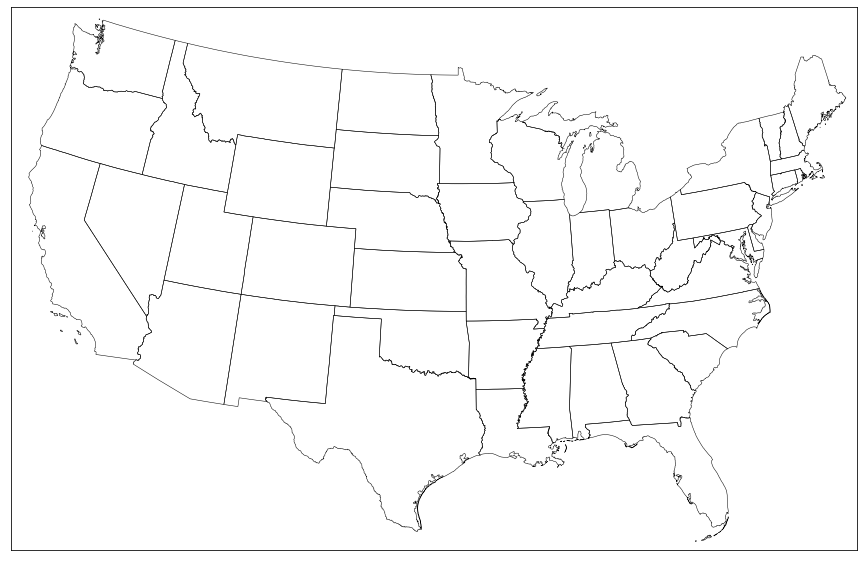

In [ ]:
df_centroid = df_centroid[df_centroid.New_cases != 0]

df_centroid = df_centroid.reset_index(drop=True)

groupby_daily = df_centroid.groupby(df_centroid["Date"])

i = 0
g = None
for name, group in groupby_daily:
# 2174
    if len(group) == 2174:
        fig = plt.figure(figsize=(16, 10))
        m_ = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        m_.readshapefile('/content/drive/Shared drives/Stock_Covid_Data/COVID_19/st99_d00', name='states')
        df_comb_counties_distance = combinations_distance_df(group)
        G_t = pp.Network(directed=False)
        for index_group, row_group in group.iterrows():
            if row_group["New_cases"] >= 0:
                G_t.add_node(str(row_group["Combined_Key"]))
        m_.scatter(group["Long_"].tolist(), group["Lat"].tolist(), latlon=True, s=25, c="red", marker='o')    
        for index, row in df_comb_counties_distance.iterrows():
            if row["Distance"] < 100:
                tuple_county = row["Combinations"]
                if str(tuple_county[0]) in G_t.nodes and str(tuple_county[1]) in G_t.nodes:
                    G_t.add_edge(str(tuple_county[0]), str(tuple_county[1]))
        plt.title(str(name), fontsize=20)
        
        g = G_t
#         print(name)


#         pp.visualisation.plot(G_t)    
    # print(len(group))
        
style = {'width': 1000, 
          'height': 1000
        }
pp.visualisation.export_html(g, 'my_temporal_network.html')
pp.visualisation.plot(g,**style)

# Complex Network Analysis for Trend and Seasonality


In [ ]:
# trend_seasonality_df = trend_seasonality_df[trend_seasonality_df["Date"] == "2020-7-27"]

# print(len(trend_seasonality_df["Trend"]))
# print(trend_seasonality_df["Trend"].max())

# print(trend_seasonality_df["Seasonal"].min())
# print(trend_seasonality_df["Seasonal"].max())


In [ ]:
# trend_seasonality_df['bin'] = pd.qcut(trend_seasonality_df['Trend'], q=10
#                                       )

# # print(trend_seasonality_df)

# groupby_bin = trend_seasonality_df.groupby(trend_seasonality_df["bin"])

# for name, group in groupby_bin:
#   print(len(group))

# # array = trend_seasonality_df["bin"].unique()

# # array[0]




In [ ]:
def combinations_bin_counties(df_original):
    counties  = df_original["Combined_Key"]

    list_of_counties_combinations = list(itertools.combinations(counties,2))

    df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

    return df_to_return

In [ ]:
# trend_seasonality_df = trend_seasonality_df[trend_seasonality_df.Trend != 0]

# trend_seasonality_df = trend_seasonality_df.reset_index(drop=True)

groupby_daily = trend_seasonality_df.groupby(trend_seasonality_df["Date"])
g = None
for name, group in groupby_daily: 
  if name == "2020-4-15" :
    G_t = pp.Network(directed=False)

    group['bin'] = pd.qcut(group['Trend'], q=30, duplicates='drop')

    groupby_bin = group.groupby(group["bin"])
    for name_bin, group_bin in groupby_bin:
      df_comb_counties_bin = combinations_bin_counties(group_bin)
      for index_group, row_group in group_bin.iterrows():
        if row_group["New_cases"] >= 10:
          G_t.add_node(str(row_group["Combined_Key"]))
      for index_bin, row_bin in df_comb_counties_bin.iterrows():
        tuple_county = row_bin["Combinations"]
        if str(tuple_county[0]) in G_t.nodes and str(tuple_county[1]) in G_t.nodes:
          G_t.add_edge(str(tuple_county[0]), str(tuple_county[1]))      
    g = G_t



style = {'width': 2000, 
          'height': 1000
        }
pp.visualisation.export_html(g, 'my_temporal_network.html')
pp.visualisation.plot(g,**style)



## Computing Stock paramaters - Abnormal price and Volatality:

In [ ]:
df_snp500 = df_with_missing[['Date','Adj_Close_SP500']]
df_snp500.set_index('Date', inplace = True)
df_snp500['Adj_Close_SP500'] = df_snp500['Adj_Close_SP500'].astype(float)

<Figure size 432x288 with 0 Axes>

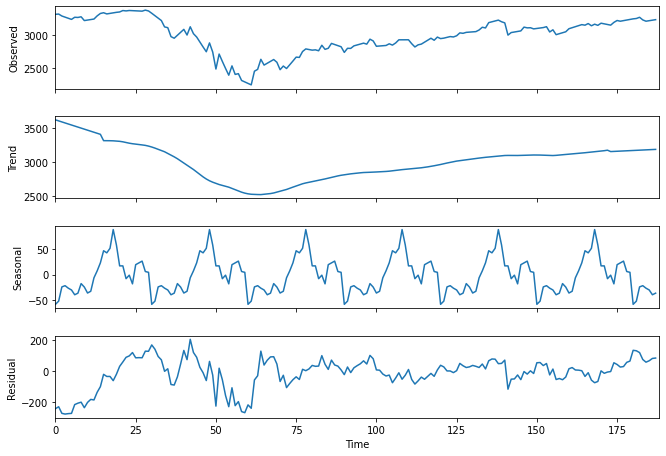

In [ ]:
result = seasonal_decompose(df_snp500['Adj_Close_SP500'].values, model='additive', freq=30, extrapolate_trend='freq')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 7)

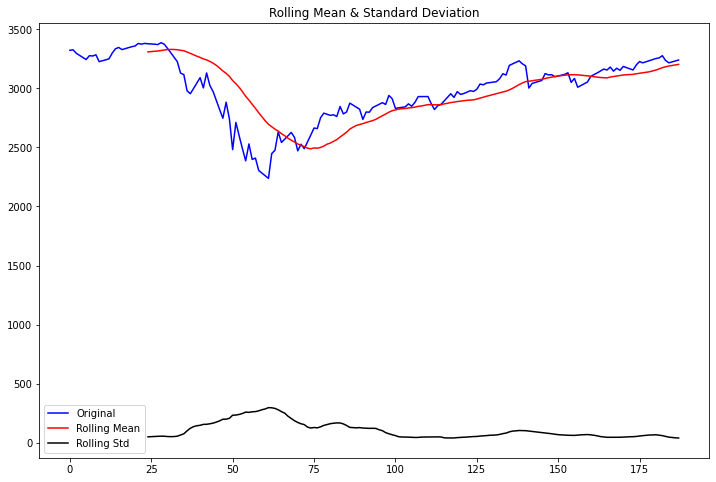

Results of Dickey-Fuller Test:
p-value = 0.4055. The series is likely non-stationary.
Test Statistic                  -1.750116
p-value                          0.405494
#Lags Used                      11.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 25, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

test_stationarity(df_snp500['Adj_Close_SP500'])

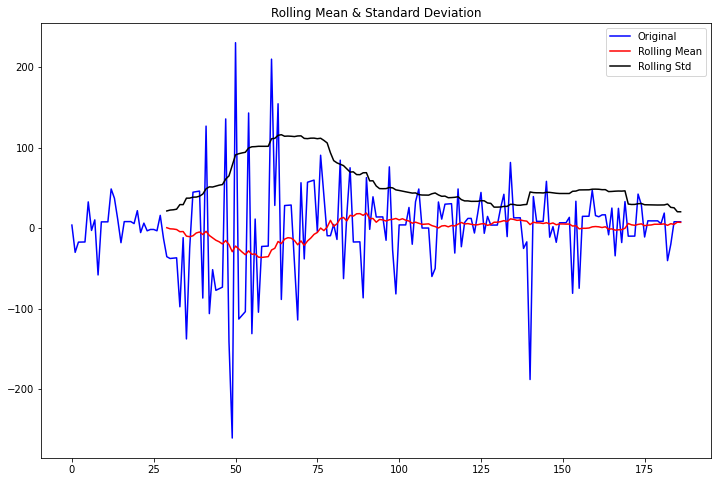

Results of Dickey-Fuller Test:
p-value = 0.0246. The series is likely non-stationary.
Test Statistic                  -3.126904
p-value                          0.024625
#Lags Used                      10.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
df_snp500['SP_First_Difference'] = df_snp500['Adj_Close_SP500'] - df_snp500['Adj_Close_SP500'].shift(1)
test_stationarity(df_snp500['SP_First_Difference'].dropna(), window = 30)

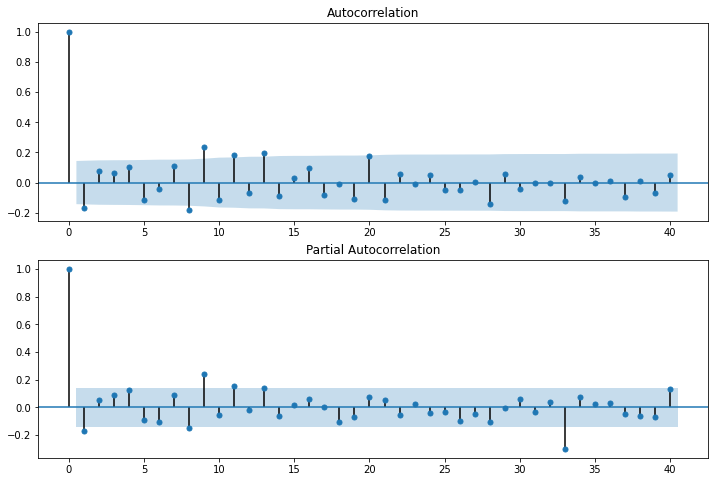

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(df_snp500['SP_First_Difference'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(df_snp500['SP_First_Difference'].dropna(), lags=40, ax=ax2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:      D.Adj_Close_SP500   No. Observations:                  187
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1019.046
Method:                       css-mle   S.D. of innovations             56.279
Date:                Thu, 03 Dec 2020   AIC                           2048.092
Time:                        23:10:48   BIC                           2064.247
Sample:                             1   HQIC                          2054.638
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.5109      4.777     -0.107      0.915      -9.875       8.853
ar.L1.D.Adj_Close_SP500     0.6487      0.283      2.292      0.023       0.094       1.203


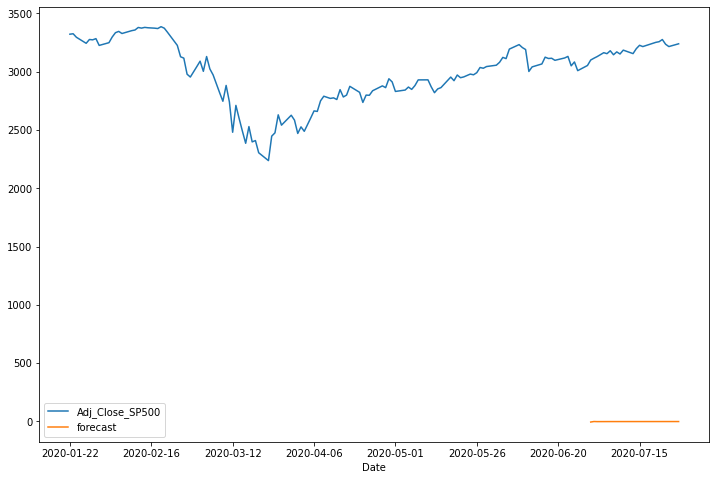

In [ ]:
arima_mod6 = sm.tsa.arima_model.ARIMA(df_snp500['Adj_Close_SP500'], (2,1,1)).fit(disp=False)
print(arima_mod6.summary())

df_snp500['forecast']=arima_mod6.predict(start=160,end=187,dynamic=True)
df_snp500[['Adj_Close_SP500','forecast']].plot(figsize=(12,8))

In [ ]:
def history_stock_analysis(X_train, X_test):

    model = auto_arima(X_train, start_p=1, start_q=1,
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=1, D=1, trace=False,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)      
    model.fit(X_train)
    stock_forecast = model.predict(n_periods=len(X_test))
    stock_forecast = pd.DataFrame(stock_forecast,index = X_test.index,columns=['Prediction'])
    actual_pred = stock_forecast.join(X_test)
    df = X_train.join(actual_pred,how="outer")
    actual_pred.plot(figsize=(7,4))

    df.plot(figsize=(10,5))

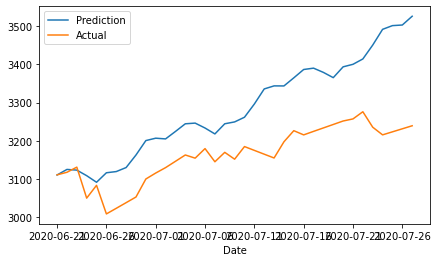

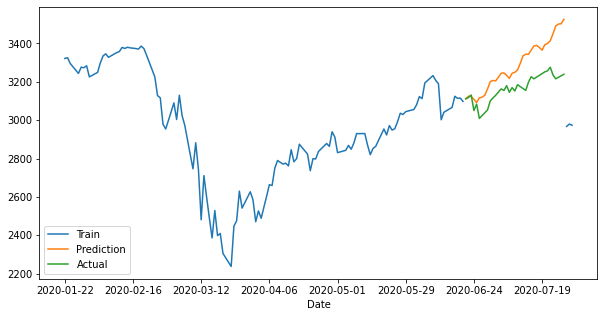

In [ ]:
X = df_snp500['Adj_Close_SP500']
X_train = pd.DataFrame(X[:150])
X_train = X_train.set_index(df_with_missing[:150]["Date"])
X_train.columns = ['Train']
X_test = pd.DataFrame(X[151:])
X_test = X_test.set_index(df_with_missing[151:]["Date"])
X_test.columns = ['Actual']

history_stock_analysis(X_train, X_test)

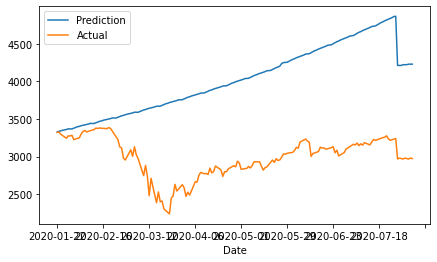

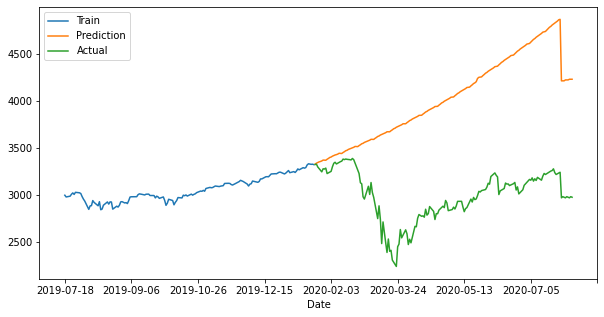

In [ ]:
df_stock_combined = pd.concat([df_with_missing_historical,df_with_missing], ignore_index=True)
df_stock_combined = df_stock_combined.drop(columns=['Adj_Close_DJI', 'Adj_Close_NASDAQ'])
df_stock_combined = df_stock_combined.set_index("Date")

df_historical = pd.DataFrame(df_with_missing_historical['Adj_Close_SP500'])
df_historical.columns = ['Train']
df_historical = df_historical.set_index(df_with_missing_historical["Date"])

df_covid = pd.DataFrame(df_with_missing['Adj_Close_SP500'])
df_covid.columns = ['Actual']
df_covid = df_covid.set_index(df_with_missing["Date"])

history_stock_analysis(df_historical, df_covid)

In [ ]:
df_snp500 = df_with_missing[['Date','Adj_Close_SP500']]

In [ ]:
df_snp500["Date"] = pd.to_datetime(df_snp500["Date"])

df_snp500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Adj_Close_SP500
0,2020-01-22,3321.750000
1,2020-01-23,3325.540039
2,2020-01-24,3295.469971
3,2020-01-25,3278.098532
4,2020-01-26,3260.818664
...,...,...
183,2020-07-23,3235.659912
184,2020-07-24,3215.629883
185,2020-07-25,3223.537100
186,2020-07-26,3231.463760


In [ ]:
df_snp500 = df_snp500.set_index("Date")



,Adj_Close_SP500
Date,
2020-01-22,3321.750000
2020-01-23,3325.540039
2020-01-24,3295.469971
2020-01-25,3278.098532
2020-01-26,3260.818664
...,...
2020-07-23,3235.659912
2020-07-24,3215.629883
2020-07-25,3223.537100


In [ ]:
df_snp500.sort_index(inplace= True)
decomposition = sm.tsa.seasonal_decompose(df_snp500["Adj_Close_SP500"].values, freq=30, extrapolate_trend='freq')

residual = decomposition.resid
seasonal = decomposition.seasonal 
trend = decomposition.trend

trend_to_plot = trend.tolist()

# fig = decomposition.plot()



In [ ]:
trend_seasonality_df = trend_seasonality_df[trend_seasonality_df["Trend"] > 0]
print(trend_seasonality_df)
groupby_daily = trend_seasonality_df.groupby(trend_seasonality_df["Date"])
array_plot_trend_average = []
for name, group in groupby_daily: 
  array_plot_trend_average.append(group["Trend"].mean())

print(len(array_plot_trend_average))

        Unnamed: 0       UID iso2  ...     Trend  Seasonal  Residual
275            275  84006023   US  ...  0.029606  0.602029 -0.631634
298            298  84006069   US  ...  0.079587 -1.241671  1.162084
3495          3495  84006023   US  ...  0.029713 -0.265288  0.235574
3518          3518  84006069   US  ...  0.078226  2.272076 -2.350303
6715          6715  84006023   US  ...  0.029821  0.843587 -0.873408
...            ...       ...  ...  ...       ...       ...       ...
605355      605355  84056037   US  ...  6.905774 -0.410884 -0.494890
605356      605356  84056039   US  ...  6.771222  0.318466  5.910312
605357      605357  84056041   US  ...  0.686254 -0.538403  1.852149
605358      605358  84056043   US  ...  0.256159  0.055595 -0.311753
605359      605359  84056045   US  ...  0.160650  0.113058  0.726292

[402950 rows x 20 columns]
188


[3625.6616623612185, 3610.477856399068, 3595.2940504369176, 3580.1102444747667, 3564.926438512616, 3549.7426325504657, 3534.5588265883152, 3519.3750206261648, 3504.191214664014, 3489.0074087018634, 3473.823602739713, 3458.6397967775624, 3443.4559908154115, 3428.272184853261, 3413.0883788911106, 3319.990147566667, 3319.8317940333336, 3318.8615031333334, 3317.4460884500004, 3314.365799416667, 3310.0349878666666, 3302.9563217, 3292.678656516667, 3282.61262835, 3274.844455716667, 3269.4381253833335, 3263.0914210999995, 3257.1492404166665, 3250.6084078833333, 3240.0089083666667, 3226.459065066666, 3210.4836634166663, 3192.1984939166664, 3174.6823195499996, 3156.808589183333, 3132.0115839833325, 3106.2525833499994, 3082.1811509499994, 3054.4117613, 3023.061024133333, 2992.448219283333, 2962.089750633333, 2929.8168033333327, 2895.7813012333336, 2859.5767991, 2823.4250282166663, 2787.74661105, 2756.4455681166664, 2730.3496767, 2709.5418479166665, 2691.6575176666665, 2675.2553829500002, 2662.49

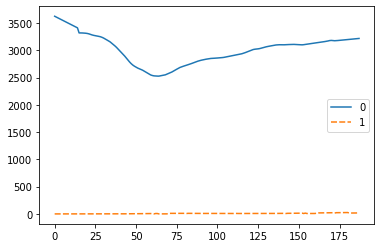

In [ ]:
sns.lineplot(data=[trend_to_plot, array_plot_trend_average])

print(trend_to_plot)
print(array_plot_trend_average)


,trend,trend_average_covid
0,0.006399,0.000036
1,0.006372,0.000036
2,0.006345,0.000036
3,0.006319,0.000035
4,0.006292,0.000035
...,...,...
183,0.005659,0.011076
184,0.005665,0.011316
185,0.005670,0.011558
186,0.005675,0.011803


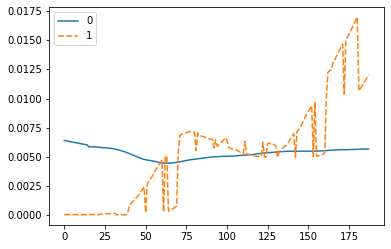

In [ ]:
df = pd.DataFrame(
    {'trend': trend_to_plot,
     'trend_average_covid': array_plot_trend_average
    })



norm1 = [float(i)/sum(trend_to_plot) for i in trend_to_plot]
norm2 = [float(i)/sum(array_plot_trend_average) for i in array_plot_trend_average]


sns.lineplot(data=[norm1, norm2])

df_norm = pd.DataFrame(
    {'trend': norm1,
     'trend_average_covid': norm2
    })

df_norm

### Kmeans CLustering Based on Trend and Seasonality

In [ ]:
trend_seasonality_df

,Unnamed: 0,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Deaths,New_cases,Centroid_Distance,Trend,Seasonal,Residual
0,0,63072001,PR,PRI,630,72001.0,Adjuntas,Puerto Rico,US,18.180117,-66.754367,"Adjuntas, Puerto Rico, US",2020-1-22,0,0,0.0,2033.528929,0.000000,0.179398,-0.179398
1,1,63072003,PR,PRI,630,72003.0,Aguada,Puerto Rico,US,18.360255,-67.175131,"Aguada, Puerto Rico, US",2020-1-22,0,0,0.0,2006.058450,0.000000,-0.217683,0.217683
2,2,63072005,PR,PRI,630,72005.0,Aguadilla,Puerto Rico,US,18.459681,-67.120815,"Aguadilla, Puerto Rico, US",2020-1-22,0,0,0.0,2003.225492,0.000000,-0.448518,0.448518
3,3,63072007,PR,PRI,630,72007.0,Aguas Buenas,Puerto Rico,US,18.251619,-66.126806,"Aguas Buenas, Puerto Rico, US",2020-1-22,0,0,0.0,2057.093220,0.000000,-0.047403,0.047403
4,4,63072009,PR,PRI,630,72009.0,Aibonito,Puerto Rico,US,18.131361,-66.264131,"Aibonito, Puerto Rico, US",2020-1-22,0,0,0.0,2057.292797,0.000000,0.501004,-0.501004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605355,605355,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,"Sweetwater, Wyoming, US",2020-7-27,221,0,6.0,962.070295,6.905774,-0.410884,-0.494890
605356,605356,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",2020-7-27,292,0,13.0,1074.431743,6.771222,0.318466,5.910312
605357,605357,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",2020-7-27,235,0,2.0,1045.925047,0.686254,-0.538403,1.852149
605358,605358,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",2020-7-27,45,0,0.0,933.668312,0.256159,0.055595,-0.311753


In [ ]:
trend_seasonality_df.loc[trend_seasonality_df['Province_State'] == "Texas"]

,Unnamed: 0,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Deaths,New_cases,Centroid_Distance,Trend,Seasonal,Residual
2601,2601,84048001,US,USA,840,48001.0,Anderson,Texas,US,31.815347,-95.653548,"Anderson, Texas, US",2020-1-22,0,0,0.0,538.417771,0.000000,-11.168692,11.168692
2602,2602,84048003,US,USA,840,48003.0,Andrews,Texas,US,32.304686,-102.637655,"Andrews, Texas, US",2020-1-22,0,0,0.0,784.210731,0.000000,-0.406278,0.406278
2603,2603,84048005,US,USA,840,48005.0,Angelina,Texas,US,31.254573,-94.609015,"Angelina, Texas, US",2020-1-22,0,0,0.0,548.886764,0.000000,-2.812041,2.812041
2604,2604,84048007,US,USA,840,48007.0,Aransas,Texas,US,28.105562,-96.999505,"Aransas, Texas, US",2020-1-22,0,0,0.0,803.948972,0.000000,-0.528797,0.528797
2605,2605,84048009,US,USA,840,48009.0,Archer,Texas,US,33.615700,-98.687546,"Archer, Texas, US",2020-1-22,0,0,0.0,549.219232,0.000000,-0.085856,0.085856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604990,604990,84048499,US,USA,840,48499.0,Wood,Texas,US,32.787224,-95.382364,"Wood, Texas, US",2020-7-27,241,5,0.0,471.952754,6.393581,-1.441491,-4.952090
604991,604991,84048501,US,USA,840,48501.0,Yoakum,Texas,US,33.173202,-102.827643,"Yoakum, Texas, US",2020-7-27,63,1,0.0,758.652499,2.081350,-0.458206,-1.623144
604992,604992,84048503,US,USA,840,48503.0,Young,Texas,US,33.176597,-98.687909,"Young, Texas, US",2020-7-27,101,3,0.0,569.766770,3.408407,-0.749694,-2.658713
604993,604993,84048505,US,USA,840,48505.0,Zapata,Texas,US,27.001564,-99.169872,"Zapata, Texas, US",2020-7-27,123,1,0.0,930.590582,4.053095,-0.572814,-3.480280


In [ ]:
trend_seasonality_df_compressed = trend_seasonality_df[["Combined_Key", "Trend", "Seasonal"]] 

In [ ]:
X= trend_seasonality_df_compressed.iloc[:, [1,2]].values

In [ ]:
from sklearn.cluster import KMeans
kmeans_inertia=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    kmeans_inertia.append(kmeans.inertia_)

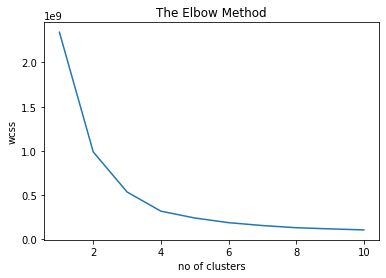

In [ ]:
plt.plot(range(1,11), kmeans_inertia)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
kmeansmodel = KMeans(n_clusters= 4, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


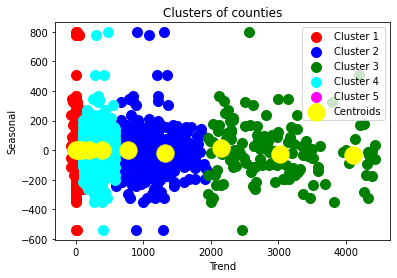

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of counties')
plt.xlabel('Trend')
plt.ylabel('Seasonal')
plt.legend()
plt.show()

In [ ]:
trend_seasonality_df_compressed.insert(3, "Cluster Group", y_kmeans, True)

In [ ]:
trend_seasonality_df_compressed

,Combined_Key,Trend,Seasonal,Cluster Group
0,"Adjuntas, Puerto Rico, US",0.000000,0.179398,0
1,"Aguada, Puerto Rico, US",0.000000,-0.217683,0
2,"Aguadilla, Puerto Rico, US",0.000000,-0.448518,0
3,"Aguas Buenas, Puerto Rico, US",0.000000,-0.047403,0
4,"Aibonito, Puerto Rico, US",0.000000,0.501004,0
...,...,...,...,...
605355,"Sweetwater, Wyoming, US",6.905774,-0.410884,0
605356,"Teton, Wyoming, US",6.771222,0.318466,0
605357,"Uinta, Wyoming, US",0.686254,-0.538403,0
605358,"Washakie, Wyoming, US",0.256159,0.055595,0


In [ ]:
trend_seasonality_df_compressed.loc[trend_seasonality_df_compressed['Combined_Key'] == "Alachua, Florida, US"]

,Combined_Key,Trend,Seasonal,Cluster Group
398,"Alachua, Florida, US",-0.249723,-1.722150,0
3618,"Alachua, Florida, US",-0.239130,-4.158331,0
6838,"Alachua, Florida, US",-0.228537,-6.006418,0
10058,"Alachua, Florida, US",-0.217943,-2.361647,0
13278,"Alachua, Florida, US",-0.207350,-0.178781,0
...,...,...,...,...
589658,"Alachua, Florida, US",99.792053,-2.361647,0
592878,"Alachua, Florida, US",101.668063,-0.178781,0
596098,"Alachua, Florida, US",103.544074,-2.176867,0
599318,"Alachua, Florida, US",105.420084,4.001237,3


# RANDOM FOREST

In [29]:
df_snp500 = df_with_missing[['Date','Adj_Close_SP500']]

df_snp500["change_price"] = df_snp500["Adj_Close_SP500"].diff()

df_snp500 = df_snp500[1:]
df_snp500

,Date,Adj_Close_SP500,change_price
1,2020-01-23,3325.540039,3.790039
2,2020-01-24,3295.469971,-30.070068
3,2020-01-25,3278.098532,-17.371439
4,2020-01-26,3260.818664,-17.279868
5,2020-01-27,3243.629883,-17.188781
...,...,...,...
183,2020-07-23,3235.659912,-40.360108
184,2020-07-24,3215.629883,-20.030029
185,2020-07-25,3223.537100,7.907217
186,2020-07-26,3231.463760,7.926660


In [32]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = df_snp500[["change_price"]].copy(), df_snp500[["change_price"]].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_price'] = up_df.loc[(up_df['change_price'] < 0), 'change_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_price'] = down_df.loc[(down_df['change_price'] > 0), 'change_price'] = 0

# We need change in price to be absolute.
down_df['change_price'] = down_df['change_price'].abs()

ewma_up = up_df['change_price'].transform(lambda x: x.ewm(span = n).mean())

ewma_down = down_df['change_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))


# Add the info to the data frame.
df_snp500['down_days'] = down_df['change_price']
df_snp500['up_days'] = up_df['change_price']
df_snp500['RSI'] = relative_strength_index

# Display the head.
df_snp500.head(30)


,Date,Adj_Close_SP500,change_price,down_days,up_days,RSI
1,2020-01-23,3325.540039,3.790039,0.000000,3.790039,100.000000
2,2020-01-24,3295.469971,-30.070068,30.070068,0.000000,9.847769
3,2020-01-25,3278.098532,-17.371439,17.371439,0.000000,6.151270
4,2020-01-26,3260.818664,-17.279868,17.279868,0.000000,4.299094
5,2020-01-27,3243.629883,-17.188781,17.188781,0.000000,3.194934
6,2020-01-28,3276.239990,32.610107,0.000000,32.610107,38.033845
7,2020-01-29,3273.399902,-2.840088,2.840088,0.000000,36.706344
8,2020-01-30,3283.659912,10.260010,0.000000,10.260010,44.745272
9,2020-01-31,3225.520020,-58.139892,58.139892,0.000000,24.444987
10,2020-02-01,3233.301201,7.781181,0.000000,7.781181,29.391841


In [36]:
# Calculate the MACD
ema_26 = df_snp500['Adj_Close_SP500'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = df_snp500['Adj_Close_SP500'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
df_snp500['MACD'] = macd
df_snp500['MACD_EMA'] = ema_9_macd

# Print the head.
df_snp500.head(30)

,Date,Adj_Close_SP500,change_price,down_days,up_days,RSI,MACD,MACD_EMA
1,2020-01-23,3325.540039,3.790039,0.000000,3.790039,100.000000,0.000000,0.000000
2,2020-01-24,3295.469971,-30.070068,30.070068,0.000000,9.847769,-0.674649,-0.374805
3,2020-01-25,3278.098532,-17.371439,17.371439,0.000000,6.151270,-1.398324,-0.794280
4,2020-01-26,3260.818664,-17.279868,17.279868,0.000000,4.299094,-2.317079,-1.310133
5,2020-01-27,3243.629883,-17.188781,17.188781,0.000000,3.194934,-3.451518,-1.947147
6,2020-01-28,3276.239990,32.610107,0.000000,32.610107,38.033845,-2.674165,-2.144209
7,2020-01-29,3273.399902,-2.840088,2.840088,0.000000,36.706344,-2.258240,-2.173067
8,2020-01-30,3283.659912,10.260010,0.000000,10.260010,44.745272,-1.455076,-2.000521
9,2020-01-31,3225.520020,-58.139892,58.139892,0.000000,24.444987,-3.761293,-2.407268
10,2020-02-01,3233.301201,7.781181,0.000000,7.781181,29.391841,-4.941734,-2.975135


In [37]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
df_snp500['Price_Rate_Of_Change'] = df_snp500['Adj_Close_SP500'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
df_snp500.head(30)

,Date,Adj_Close_SP500,change_price,down_days,up_days,RSI,MACD,MACD_EMA,Price_Rate_Of_Change
1,2020-01-23,3325.540039,3.790039,0.000000,3.790039,100.000000,0.000000,0.000000,NaN
2,2020-01-24,3295.469971,-30.070068,30.070068,0.000000,9.847769,-0.674649,-0.374805,NaN
3,2020-01-25,3278.098532,-17.371439,17.371439,0.000000,6.151270,-1.398324,-0.794280,NaN
4,2020-01-26,3260.818664,-17.279868,17.279868,0.000000,4.299094,-2.317079,-1.310133,NaN
5,2020-01-27,3243.629883,-17.188781,17.188781,0.000000,3.194934,-3.451518,-1.947147,NaN
6,2020-01-28,3276.239990,32.610107,0.000000,32.610107,38.033845,-2.674165,-2.144209,NaN
7,2020-01-29,3273.399902,-2.840088,2.840088,0.000000,36.706344,-2.258240,-2.173067,NaN
8,2020-01-30,3283.659912,10.260010,0.000000,10.260010,44.745272,-1.455076,-2.000521,NaN
9,2020-01-31,3225.520020,-58.139892,58.139892,0.000000,24.444987,-3.761293,-2.407268,NaN
10,2020-02-01,3233.301201,7.781181,0.000000,7.781181,29.391841,-4.941734,-2.975135,-0.027736


In [38]:
# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = df_snp500["Adj_Close_SP500"].transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
df_snp500['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
df_snp500.loc[df_snp500['Prediction'] == 0.0] = 1.0

# print the head
df_snp500.head(50)



,Date,Adj_Close_SP500,change_price,down_days,up_days,RSI,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
1,2020-01-23,3325.540039,3.790039,0.000000,3.790039,100.000000,0.000000,0.000000,NaN,NaN
2,2020-01-24,3295.469971,-30.070068,30.070068,0.000000,9.847769,-0.674649,-0.374805,NaN,-1.0
3,2020-01-25,3278.098532,-17.371439,17.371439,0.000000,6.151270,-1.398324,-0.794280,NaN,-1.0
4,2020-01-26,3260.818664,-17.279868,17.279868,0.000000,4.299094,-2.317079,-1.310133,NaN,-1.0
5,2020-01-27,3243.629883,-17.188781,17.188781,0.000000,3.194934,-3.451518,-1.947147,NaN,-1.0
6,2020-01-28,3276.239990,32.610107,0.000000,32.610107,38.033845,-2.674165,-2.144209,NaN,1.0
7,2020-01-29,3273.399902,-2.840088,2.840088,0.000000,36.706344,-2.258240,-2.173067,NaN,-1.0
8,2020-01-30,3283.659912,10.260010,0.000000,10.260010,44.745272,-1.455076,-2.000521,NaN,1.0
9,2020-01-31,3225.520020,-58.139892,58.139892,0.000000,24.444987,-3.761293,-2.407268,NaN,-1.0
10,2020-02-01,3233.301201,7.781181,0.000000,7.781181,29.391841,-4.941734,-2.975135,-0.027736,1.0


In [39]:
# Any row that has a `NaN` value will be dropped.
df_snp500 = df_snp500.dropna()

# Print the head.
df_snp500.head()

,Date,Adj_Close_SP500,change_price,down_days,up_days,RSI,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
10,2020-02-01,3233.301201,7.781181,0.0,7.781181,29.391841,-4.941734,-2.975135,-0.027736,1.0
11,2020-02-02,3241.101153,7.799952,0.0,7.799952,34.362480,-5.309890,-3.485966,-0.016498,1.0
12,2020-02-03,3248.919922,7.818769,0.0,7.818769,39.304540,-5.078070,-3.827883,-0.008901,1.0
13,2020-02-04,3297.590088,48.670166,0.0,48.670166,60.607555,-2.089495,-3.459980,0.011277,1.0
14,2020-02-05,3334.689941,37.099853,0.0,37.099853,69.899651,2.324796,-2.249801,0.028074,1.0


In [43]:
# Grab our X & Y Columns.
X_Cols = df_snp500[['RSI','Price_Rate_Of_Change','MACD']]
Y_Cols = df_snp500['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

y_pred

array([ 1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,
       -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.])

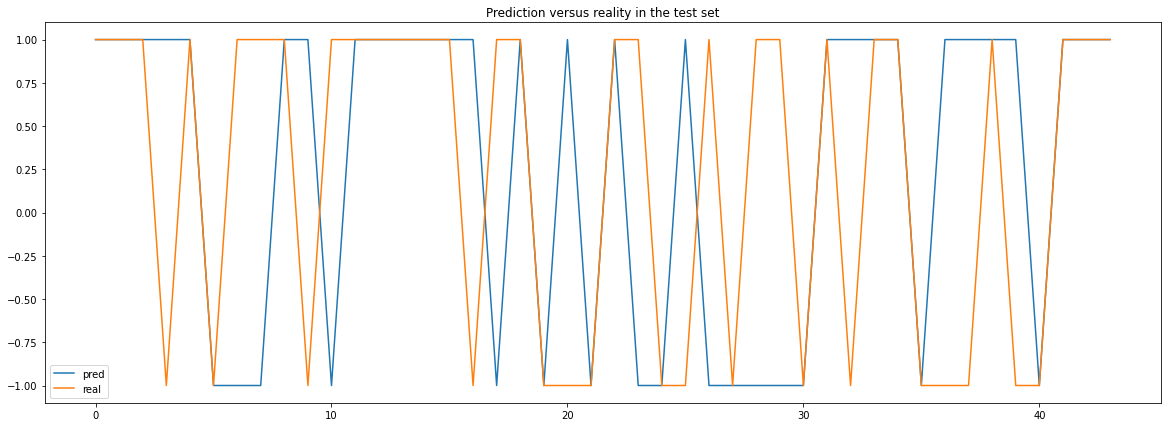

In [45]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(y_pred)), y_pred, label='pred')
plt.plot(np.arange(len(y_test)), y_test, label='real' );
plt.title('Prediction versus reality in the test set')
plt.legend();

<Figure size 1440x504 with 0 Axes>

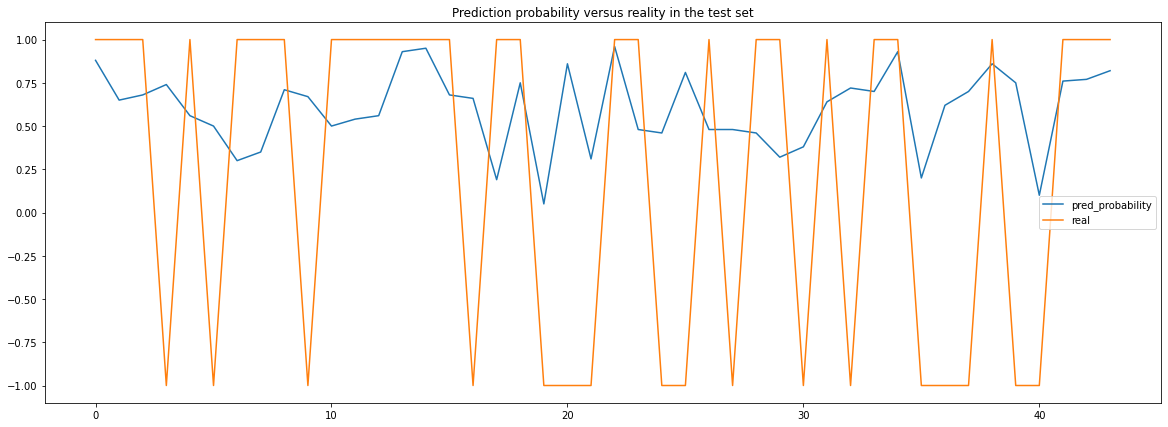

In [47]:
plt.figure(figsize=(20,7))
proba = rand_frst_clf.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(proba)), proba, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, label='real' );
plt.title('Prediction probability versus reality in the test set');
plt.legend();
plt.show();